### Machine Learning in Computer Vision Hands-on using scikit-learn library for pemilu digits recognition

#### Background
In 2014 Presidential election, the result for each election booth in the form of C1 is uploaded into KPU webserver.
A crowdsourcing effort, kawalpemilu.org, label the tally result into number that can be counted by computer. Then we can scrapped both images and label to create dataset for digit images.

For more information regarding the digit extraction procedure, you can visit https://mitbal.wordpress.com/2014/10/10/pemilu-presiden-indonesia-2014-pendekatan-pembelajaran-mesin/

Now let's see if we can automatically predict each individual digits using machine learning algorithm.

#### Why this setup?
Python is one of the most popular chosen language for data science and machine learning. One of the reasons is it is clear and concise language, easy to use and easy to code. 
One of the downside is maybe its slow execution time. However, for critical part of the code is usually implemented in C, and then called via wrapper in python. Therefore you get the expressive power in python with speed.

In this project, we use one of the most popular machine learning, scikit-learn. It provides complete end-to-end machine learning pipeline, starting from preprocessing. It is also regularly updated and even provides new and state-of-the-art algorithm.

Jupyter notebook is a platform to code, document, and visualize experiment in machine learning. It can be called IDE for data science, although it is hard to use it collaboratively.

First, let's just import all necessary modules for this project. Library in python can easily be installed via package manager pip or conda.

In [30]:
import glob

import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import normalize
from sklearn.linear_model import SGDClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Reading the data
Now let's read all image and load it into a numpy array

In [2]:
input_dir = '/home/mitbal/workspace/itdel/pemilu/'
dataset = np.zeros((20000, 50*100))
label = np.zeros((20000, ))
counter = 0
for i in xrange(10):
    files = glob.glob(input_dir + str(i) + '/*.png')
    
    for f in files:
        im = io.imread(f)
        dataset[counter, :] = im.flatten()
        label[counter] = i
        
        counter += 1

In total there are 20000 images, for class 0 to 9. Each class have 2000 samples.

#### Exploration
We'll sample 100 images from each classes and plot the sample image

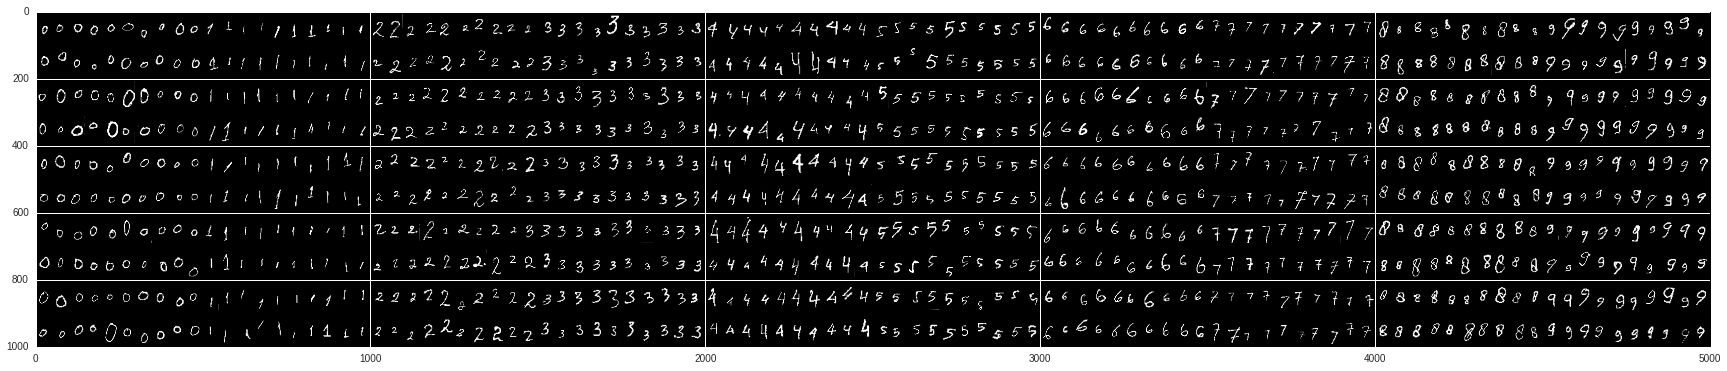

In [3]:
img = np.zeros((1000, 5000))
for i in xrange(10):
    for j in xrange(10):
        for k in xrange(10):
            img[k*100:(k+1)*100, i*500+j*50:i*500+(j+1)*50] = np.reshape(dataset[i*2000+j*10+k, :], (100, 50))

fig, ax = plt.subplots(figsize=(30, 20))
plt.imshow(img, cmap='gray')

It is a good practice to just look into the data before we even applying any machine learning algorithm. Just to get the feel of the data.

Next we'll investigate how the data live in high-dimensional feature space using 2 popular visualization techniques, PCA and t-SNE.

PCA is using linear transformation to the direction of the highest variance.
Meanwhile, t-sne can detect non-linear manifold in the feature space.

In [4]:
def plot_pca(X, y):
    pca = PCA(n_components=2)
    output = pca.fit_transform(X)

    plt.subplots(figsize=(30, 20))
    categories = set(y)
    for cat in categories:
        subset = np.array([a for a,b in zip(output, y) if b == cat])
        plt.plot(subset[:, 0], subset[:, 1], color=np.random.random((3,)), label=str(cat), marker='o', linewidth=0)
    plt.legend()
    
def plot_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=0, perplexity=50)
    output = tsne.fit_transform(X)

    plt.subplots(figsize=(30, 20))
    categories = set(y)
    for cat in categories:
        subset = np.array([a for a,b in zip(output, y) if b == cat])
        plt.plot(subset[:, 0], subset[:, 1], color=np.random.random((3,)), label=str(cat), marker='o', linewidth=0)
    plt.legend()

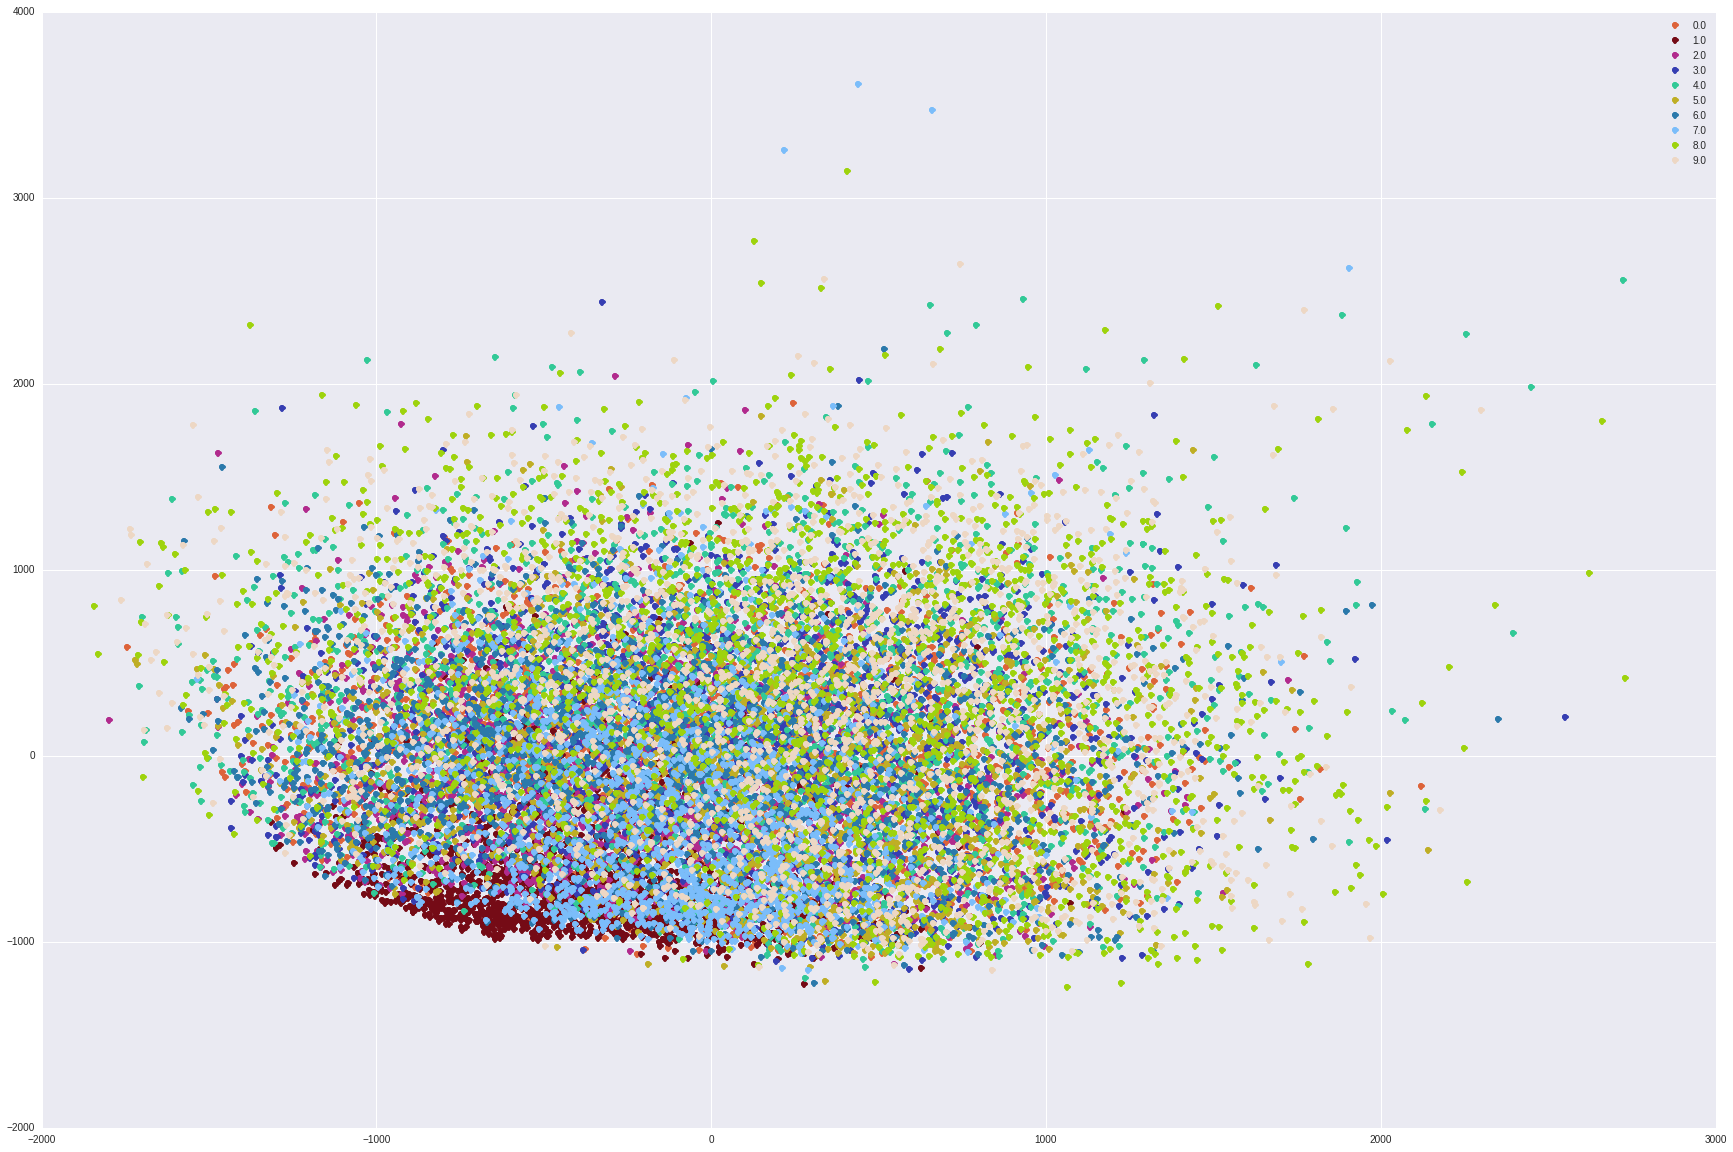

In [5]:
plot_pca(dataset, label)

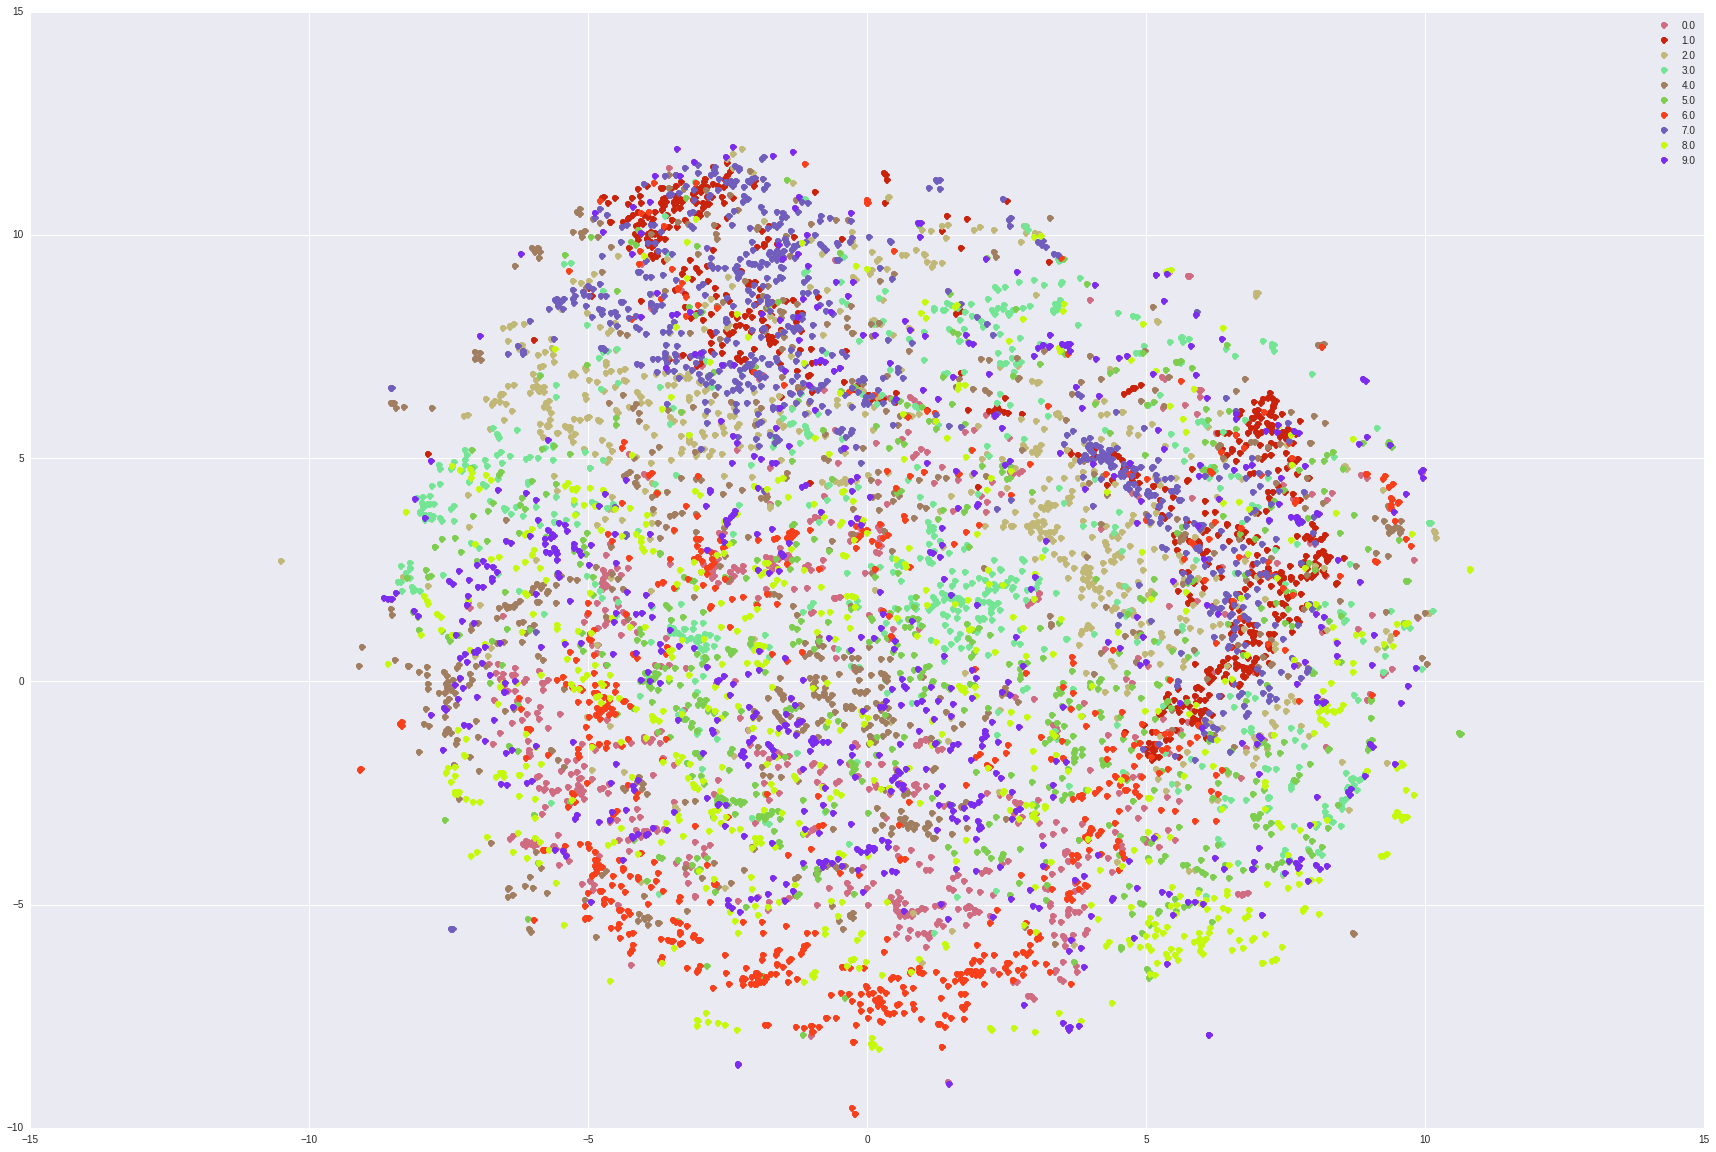

In [6]:
plot_tsne(dataset[range(0, 20000, 4), :], label[range(0, 20000, 4)])

As can be seen in above figure, the class is overlapped. The PCA plot is even harder to see. This suggest that it might be difficult to classify them correctly.

#### Divide data into training and testing

We divide our dataset into 2 parts, training and testing.
Reducing training error into zero is pretty trivial using algorithm such as nearest neighbor. However, that's not our goal. Our goal is to reduce generalization error, the error the algorithm make when it face unseen data.
That's why we train using training dataset, and then perform evaluation using testing dataset.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=0)

#### Normalization

Some algorithm is sensitive to the scale of the data. That's why it is good practice to normalize the data first before inputted into machine learning algorithm.

There are several different techniques for normalization. One of the most commonly used is to normalize each features by reducing the mean and divide it using its standard deviation (usually called standardization) and then normalized the length of each input into unit vector.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = normalize(X_train)
X_test = normalize(X_test)

Let's try our first parameterized model, logistic regression. Or more aptly, softmax regression because it is multi class 

In [57]:
sgd = SGDClassifier(loss='log', alpha=0.001)
sgd.fit(X_train, y_train)
prediction = sgd.predict(X_test)

Let's see how well it performs

In [10]:
def get_acc(prediction, label):
    print 'acc', (sum(prediction == label) / float(len(label))) * 100, '%'

In [58]:
get_acc(prediction, y_test)

acc 42.0 %


Another good way to inspect the performance is by looking at the confusion matrix

In [48]:
def get_confusion_matrix(prediction, label):
    matrix = np.zeros((10, 10))
    
    for i, j in zip(prediction, label):
        matrix[int(i), int(j)] += 1
    
    print matrix

In [49]:
get_confusion_matrix(prediction, y_test)

[[ 267.    7.   11.   12.    6.    3.   18.    7.   21.   22.]
 [  10.  327.    3.    1.    8.    0.    8.    5.    5.    7.]
 [  13.    9.  334.   33.    5.   24.   19.   11.   14.   17.]
 [  12.    0.   17.  271.    4.   11.    3.    4.   13.   22.]
 [   1.   12.    2.    0.  304.    1.    3.    7.    3.   18.]
 [  15.    0.    6.   14.    1.  315.   29.   11.   14.   13.]
 [  13.   13.   12.    3.   13.    9.  288.    8.    7.    2.]
 [   7.    6.    6.   16.    7.   13.    1.  334.    8.   18.]
 [  40.    2.    9.   22.   17.    6.   18.    9.  311.   33.]
 [  16.    3.   16.   48.   20.    7.   12.   12.   15.  247.]]


Now let's try cross validation.
to find the best hyperparameter.

In [12]:
from sklearn.model_selection import cross_val_score
clf = SGDClassifier(loss='log', alpha=0.0001)
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([ 0.41903276,  0.434375  ,  0.42888403,  0.42450766,  0.43572099])

In [13]:
scores.mean()

0.42850408692772685

In [14]:
import math
alphas = [0.00001*math.pow(10, i) for i in xrange(4)]
alphas

[1e-05, 0.0001, 0.001, 0.01]

In [51]:
for alpha in alphas:
    clf = SGDClassifier(loss='log', alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print alpha, scores.mean()

1e-05 0.340137724741
0.0001 0.431937844461
0.001 0.425067641251
0.01 0.380126437159


It looks like it perform best with alpha equals to Lets try on the testing dataset

In [52]:
sgd = SGDClassifier(loss='log', alpha=0.0001)
sgd.fit(X_train, y_train)
prediction = sgd.predict(X_test)

get_acc(prediction, y_test)

acc 43.15 %


### Feature engineering
Okay, now let's try different features description. In practice, better representation is often

#### PCA
Before, we use PCA for visualization. However, PCA is often used as dimensionality reduction techniques.
It used to be popular feature for face detection. In this case it is called as eigenface

In [18]:
pca = PCA(n_components=300)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
reduced_train = pca.transform(X_train)
reduced_test = pca.transform(X_test)

In [20]:
sgd = SGDClassifier(loss='log')
sgd.fit(reduced_train, y_train)
prediction = sgd.predict(reduced_test)

get_acc(prediction, y_test)

acc 43.425 %


In this case, we get almost the same result from using raw pixel features. However, now we can achieve this using much lower number of features (300 vs 5000). In practice, using fewer features is favoured as it will give usually better generalization due to bias-variance theorem.

#### HOG features
Histogram of Gradient (HOG) is a popular, originating in used for pedestrian detection.

The basic idea is to count the gradient/direction in each cells of the image

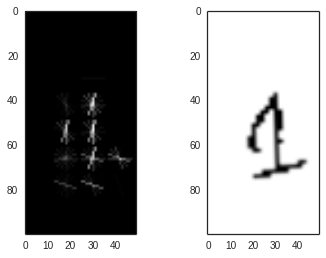

In [43]:
from skimage.feature import hog

example_image = np.reshape(dataset[2001, :], (100, 50))
fd, hog_image = hog(example_image, orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualise=True)

sns.set_style('white')

plt.subplot(1, 2, 1)
plt.imshow(hog_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(example_image)

In [22]:
num_train = len(X_train)
num_features = fd.shape[0]
fd_trains = np.zeros((num_train, num_features))
for i in xrange(num_train):
    fd, hog_image = hog(np.reshape(X_train[i, :], (100, 50)), orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualise=True)
    fd_trains[i, :] = fd

In [23]:
num_test = len(X_test)
fd_test = np.zeros((num_test, num_features))
for i in xrange(num_test):
    fd, hog_image = hog(np.reshape(X_test[i, :], (100, 50)), orientations=8, pixels_per_cell=(12, 12), cells_per_block=(1, 1), visualise=True)
    fd_test[i, :] = fd

In [24]:
sgd = SGDClassifier(loss='log')
sgd.fit(fd_trains, y_train)
prediction = sgd.predict(fd_test)

get_acc(prediction, y_test)

acc 74.95 %


Our better number yet. Better features usually have better separability. Let's' plot another t-sne

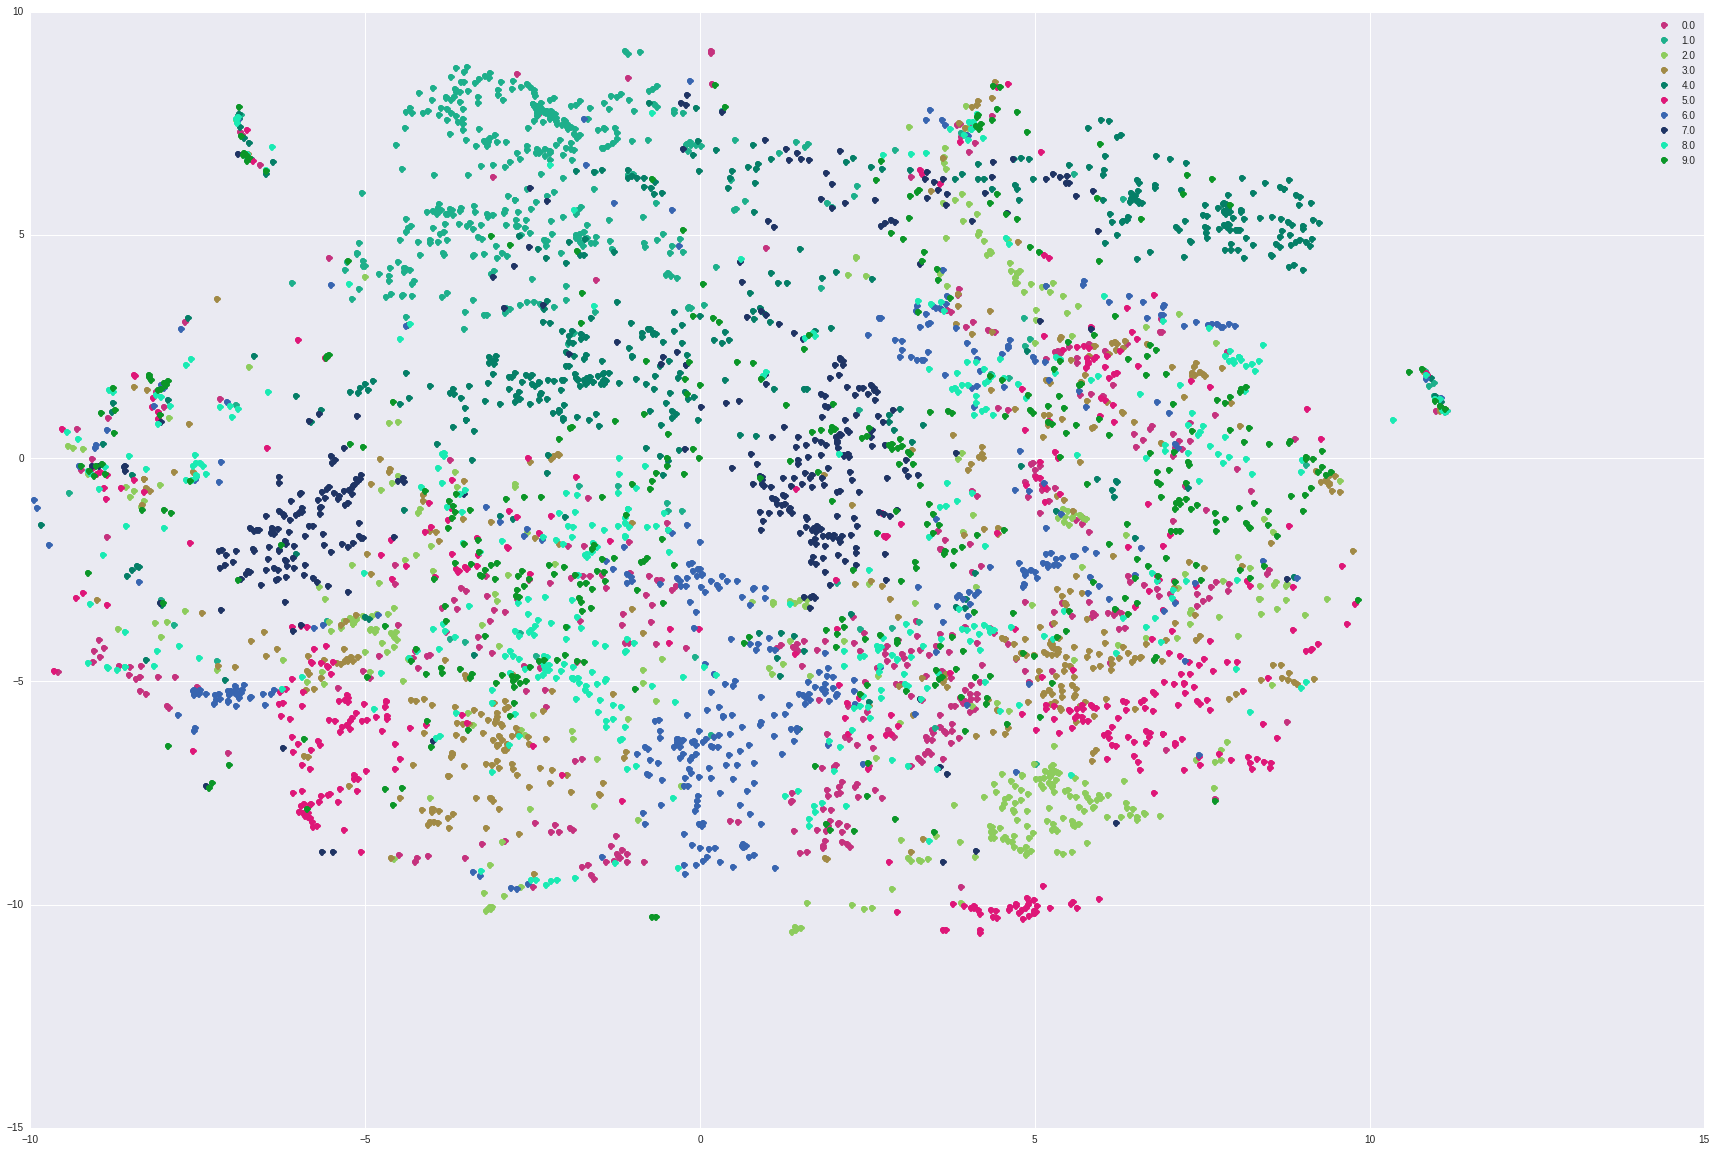

In [28]:
plot_tsne(fd_trains[range(0, num_train, 4), :], y_train[range(0, num_train, 4)])

### Conclusion

So there you have it.

Machine learning algorithm is just one piece in the pipeline. 
Sometimes it is even better to have clean data (both for its label and its raw value) and better designed features/representatives. Algorithm then come last. The hierarchy is usually like this.

DATA > FEATURE > ALGORITHM

For successful machine learning project it is also necessary to have these characteristics:
- Proper data with correct label
- Proper preprocessing
- Proper evaluation

If we have deployed the system, then it will then need proper monitoring, proper tracking, and proper logging. Especially for ever changing problem such as for fraud detection system.

In the next lab session, we will see how learn the features directly from the data, using deep learning family of algorithm, convolutional neural network (ConvNet). Stay Tuned!!!